In [1]:
# необходимо понимать то, как работает обратный проход по сети
# в этом ноутбуке мы пройдем по нейросети из прошлого ноутбука №3

# код нейросети и обучения будет аналогичным, за исключением того, что мы уйдем от loss.backward() и напишем все градиенты руками

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
# построим словарь отображения из букв в индексы
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
# и наоборот
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# построим датасет
block_size = 3  # длина контекста: сколько букв учитывать при предсказании следующей буквы

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # обрезаем и добавляем
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Вернемся к коду нейросети

In [6]:
# создадим функцию для проверки того, что мы считаем градиенты верно
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()  # сравним с тем, что считает pytorch, точное совпадение
    app = torch.allclose(dt, t.grad)  # приближенное сравнение
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)  # embeddings
# 1 слой
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g) * (5/3)/((n_embd*block_size)**0.5)  # weights of 1 layer
b1 = torch.randn(n_hidden , generator=g) * 0.1  # bias of 1 layer, с batchnorm он бесполезен, используем просто так
# 2 слой
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.1  # weights of 2 layer
b2 = torch.randn(vocab_size , generator=g) * 0.1  # bias of 2 layer
# bacthnorm
bngain = torch.randn((1, n_hidden))*0.1 + 1.0  # масштаб batchnorm
bnbias = torch.randn((1, n_hidden))*0.1  # смещение batchnorm

# Инциализируем параметры нестандартно, потому что с инициализацией нулями нам будет трудно убедиться, что мы правильно посчитали градиенты

parameters = [C, W1, b1, W2, b2, bngain, bnbias]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size  # переменная для удобства, пригодится
# minibatch construct
ix = torch.randint (0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

In [9]:
# forward pass
# разрезан на более подробные кусочки, чтобы было удобно считать по каждому градиенты

emb = C[Xb]  # [batch_size, block_size, embd], переводим индексы букв в векторы
embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size], соединяем все векторы букв в один

# Linear layer 1
hprebn = embcat @ W1 + b1  # преактивация скрытого слоя

# BatchNorm Layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)  # запишем среднее на i итерации
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)  # поправка на число степеней свободы n-1 не n
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Нелинейность
h = torch.tanh(hpreact)

# Linear layer 2
logits = h @ W2 + b2  # [batch_size, vocab_size], выходной слой

# cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values  # считаем максимумы для каждого выхода
norm_logits = logits - logit_maxes  # вычитаем максимумы, тем самым повысим высилительную стабильнось без изменения результатаэ
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Pytorch backward pass
for p in parameters:
    p.grad = None

# говорим торчу, что нам нужны градиенты для всех этих значений
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
    t.retain_grad()

loss.backward()
loss

tensor(3.3595, grad_fn=<NegBackward0>)

# Упражнение 1

In [11]:
# Пройтись по всем градиентам вручную, через все переменные, заданные в прямом проходе выше, явно

# cmp('logprobs', dlogprobs, logprobs)
# cmp('probs', dprobs, probs)
# cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
# cmp('counts_sum', dcounts_sum, counts_sum)
# cmp('counts', dcounts, counts)
# cmp('norm_logits', dnorm_logits, norm_logits)
# cmp('logit_maxes', dlogit_maxes, logit_maxes)
# cmp('logits', dlogits, logits)
# cmp('h', dh, h)
# cmp('W2', dW2, W2)
# cmp('b2', db2, b2)
# cmp('hpreact', dhpreact, hpreact)
# cmp('bngain', dbngain, bngain)
# cmp('bnbias', dbnbias, bnbias)
# cmp('bnraw', dbnraw, bnraw)
# cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# cmp('bnvar', dbnvar, bnvar)
# cmp('bndiff2', dbndiff2, bndiff2)
# cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

### dlogprobs = ???

In [12]:
# dlogprobs = ???
# loss = -logprobs[range(n), Yb].mean()
logprobs.shape  # размеры переменной и ее градиента должны совпадать

torch.Size([32, 27])

In [13]:
# loss = -(a +b + c) / 3
# dloss/da = -1/3
# dloss/da = -1/n

# получается что производная будет просто -1/n для значений, которые участвуют в подсчете
# для тех, кто не участвует интуитивно понятно, что градиенты будут 0

In [14]:
dlogprobs = torch.zeros(logprobs.shape)
dlogprobs.shape

torch.Size([32, 27])

In [15]:
dlogprobs[range(n), Yb] = -1/n
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


### dprobs = ???

In [16]:
# logprobs = probs.log()

In [17]:
# dlog(x) = 1/x + chainrule
dprobs = 1.0 / probs * dlogprobs
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


### dcounts_sum_inv = ???

In [18]:
# probs = counts * counts_sum_inv

In [19]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [20]:
# torch неявно копирует при прямом проходе значения counts_sum_inv, чтобы получилось сделать унможение
# c = a * b
# a[3x3] * b [3x1] ->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# c[3x3]

In [21]:
# здесь под капотом 2 операции, унможение и копирование по колонкам, сначала мы идем через уножение, потом через копирование
# при использовании одной переменной несколько раз ее градиенты суммируются
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


### dcounts = ???, but not yet

In [22]:
# probs = counts * counts_sum_inv

In [23]:
dcounts = counts_sum_inv * dprobs

In [24]:
cmp('counts', dcounts, counts)

counts          | exact: False | approximate: False | maxdiff: 0.00569312646985054


In [25]:
# мы получаем неверный результат, потому что counts_sum_inv зависит от counts_sum и зависит как следствие от counts
# у нас есть вторая ветка, которую нужно сюда присуммировать

### dcounts_sum = ???

In [26]:
# counts_sum_inv = counts_sum**-1
dcounts_sum = -1 * counts_sum**-2 * dcounts_sum_inv

In [27]:
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


### dcounts = ???

In [28]:
counts.shape

torch.Size([32, 27])

In [29]:
# counts_sum = counts.sum(1, keepdim=True)
# probs = counts * counts_sum_inv

In [30]:
(counts_sum_inv * dprobs).shape, dcounts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [31]:
# a11 a12 a13  ---> b1 (= a11 + a12 + a13)
# a21 a22 a23  ---> b2 (= a21 + a22 + a23)
# a31 a32 a33  ---> b3 (= a31 + a32 + a33)

# когда придет градиент, он должен скопироваться на всех участников суммы, и сделает он это по горизонтали
# то есть мы должны скопировать d_counts_sum [32x1] ---> [32, 27]

In [32]:
dcounts += torch.ones_like(counts) * dcounts_sum  # добавляем с другой ветки

In [33]:
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


### dnorm_logits = ???

In [34]:
# counts = norm_logits.exp()

In [35]:
# производная экспоненты - экспонента
dnorm_logits = norm_logits.exp() * dcounts

In [36]:
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


### dlogit_maxes = ???

In [37]:
dnorm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [38]:
# c11 c12 c13  = a11 a12 a13   b1
# c21 c22 c23  = a21 a22 a23 - b2
# c31 c32 c33  = a31 a32 a33   b3

# broadkasting
# c11 c12 c13  = a11 a12 a13   b1 b1 b1
# c21 c22 c23  = a21 a22 a23 - b2 b2 b2
# c31 c32 c33  = a31 a32 a33   b3 b3 b3

# e.g. c32 = a32 - b3

In [39]:
# norm_logits = logits - logit_maxes
dlogit_maxes = (-1 * dnorm_logits).sum(1, keepdim=True)

# сразу посчитаем dlogits для данного выражения
dlogits = dnorm_logits.clone()

In [40]:
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


In [41]:
# мы говорили раньше о том, что вычитание максимум из логитов не меняет никак вероятности и не меняет лосс
# значит мы ожидаем, что градиенты через максимумы почти не пойдут, вернее даже будут нулями
# в общем здесь мы это и видим, с точностью до вычислений чисел с плавающей точкой
dlogit_maxes

tensor([[ 2.3283e-10],
        [-4.6566e-09],
        [ 0.0000e+00],
        [-9.3132e-10],
        [ 5.5879e-09],
        [-4.4238e-09],
        [-6.5193e-09],
        [ 2.7940e-09],
        [ 5.1223e-09],
        [-9.3132e-10],
        [ 2.3283e-09],
        [ 1.1642e-09],
        [ 6.9849e-10],
        [-9.3132e-10],
        [-3.4925e-09],
        [-5.1223e-09],
        [-5.1223e-09],
        [-2.0955e-09],
        [-1.1642e-09],
        [-2.7940e-09],
        [ 9.3132e-10],
        [-6.9849e-10],
        [ 2.5611e-09],
        [ 0.0000e+00],
        [-1.8626e-09],
        [-4.4238e-09],
        [-9.3132e-10],
        [ 5.5879e-09],
        [-1.8626e-09],
        [ 2.5611e-09],
        [ 4.6566e-09],
        [ 2.3283e-10]], grad_fn=<SumBackward1>)

### dlogits = ???

In [42]:
# logit_maxes = logits.max(1, keepdim=True).values
# здесь получается так, что градиент пойдет по тем местам, откуда был взят максимум
dlogits2 = torch.zeros_like(logits)
dlogits2[torch.arange(n), logits.argmax(1)] = dlogit_maxes.squeeze()  # сжимаем в вектор длины n

# альтернативный способ
dlogits2 = F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

In [43]:
dlogits += dlogits2

In [44]:
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


### dh = ???

In [45]:
# logits = h @ W2 + b2
dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [46]:
# разберем на простом примере и обобщим производные

In [47]:
# logits = h @ W + b
# assume h -> [2, 3], W -> [3, 4], b -> [4]. dL/dlogits должна быть [2, 4], такой же как результат этого выражения
# dL/dh должна быть как h 2х3, dL/dW должна быть как W 3х4

# 
#     h11 h12 h13
# h = h21 h22 h23

#     W11 W12 W13 W14
# W = W21 W22 W23 W24
#     W31 W32 W33 W34

# 
# b = b1 b2 b3 b4
# 
#          h11*W11 + h12*W21 + h13*W31 + b1  h11*W12 + h12*W22 + h13*W32 + b2  h11*W13 + h12*W23 + h13*W33 + b3  h11*W14 + h12*W24 + h13*W34 + b4
# logits = h21*W11 + h22*W21 + h23*W31 + b1  h21*W12 + h22*W22 + h23*W32 + b2  h21*W13 + h22*W23 + h23*W33 + b3  h21*W14 + h22*W24 + h23*W34 + b4
# 
# нам нужно найти производную dL по dh
# для каждого dh посмотрим, в каких местах матрицы он вообще встречается, например h11 встречается в logits11, logits12, logits13, logits14
# производная для h11 в первом слагаемом = W11, второе слагаемое приходит с места, где еще использовался h11 - это logits12, оттуда
# производная = W12, дальше по аналогии еще 2 слагаемых и так далее для других h
# 
# dL/dh11 = dL/dlogits11 * W11 + dL/dlogits12 * W12 + dL/dlogits13 * W13 + dL/dlogits14 * W14
# dL/dh12 = dL/dlogits11 * W21 + dL/dlogits12 * W22 + dL/dlogits13 * W23 + dL/dlogits14 * W24
# dL/dh13 = dL/dlogits11 * W31 + dL/dlogits12 * W32 + dL/dlogits13 * W33 + dL/dlogits14 * W34

# dL/dh21 = dL/dlogits21 * W11 + dL/dlogits22 * W12 + dL/dlogits23 * W13 + dL/dlogits24 * W14
# dL/dh22 = dL/dlogits21 * W21 + dL/dlogits22 * W22 + dL/dlogits23 * W23 + dL/dlogits24 * W24
# dL/dh23 = dL/dlogits21 * W31 + dL/dlogits22 * W32 + dL/dlogits23 * W33 + dL/dlogits24 * W34

# получается это тоже самое что

#                                                                                     W11 W21 W31
# dL/dh11 dL/dh12 dL/dh13     dL/dlogits11 dL/dlogits12 dL/dlogits13 dL/dlogits14     W12 W22 W32
# dL/dh21 dL/dh22 dL/dh23  =  dL/dlogits21 dL/dlogits22 dL/dlogits23 dL/dlogits24  @  W13 W23 W33
#                                                                                     W14 W24 W34

#  [2x3] = [2x4] @ [4x3]
# а это тоже самое что
# dL/dlogits @ W.T

In [48]:
# аналогичную картину можно получить и для W

# 
#     h11 h12 h13
# h = h21 h22 h23

#     W11 W12 W13 W14
# W = W21 W22 W23 W24
#     W31 W32 W33 W34

# 
# b = b1 b2 b3 b4
# 
#          h11*W11 + h12*W21 + h13*W31 + b1  h11*W12 + h12*W22 + h13*W32 + b2  h11*W13 + h12*W23 + h13*W33 + b3  h11*W14 + h12*W24 + h13*W34 + b4
# logits = h21*W11 + h22*W21 + h23*W31 + b1  h21*W12 + h22*W22 + h23*W32 + b2  h21*W13 + h22*W23 + h23*W33 + b3  h21*W14 + h22*W24 + h23*W34 + b4
# 
# нам нужно найти производную dL по dW
# для каждого W посмотрим, в каких местах матрицы он вообще встречается, например W11 встречается в logits11, logits21
# производная для W11 в первом слагаемом = h11, второе слагаемое приходит с места, где еще использовался W11 - это logits21, оттуда
# производная = h21, дальше по аналогии
# 
# dL/dW11 = dL/dlogits11 * h11 + dL/dlogits21 * h21
# dL/dW12 = dL/dlogits12 * h11 + dL/dlogits22 * h21
# dL/dW13 = dL/dlogits13 * h11 + dL/dlogits23 * h21
# dL/dW14 = dL/dlogits14 * h11 + dL/dlogits24 * h21

# dL/dW21 = dL/dlogits11 * h12 + dL/dlogits21 * h22
# dL/dW22 = dL/dlogits12 * h12 + dL/dlogits22 * h22
# dL/dW23 = dL/dlogits13 * h12 + dL/dlogits23 * h22
# dL/dW24 = dL/dlogits14 * h12 + dL/dlogits24 * h22

# dL/dW31 = dL/dlogits11 * h13 + dL/dlogits21 * h23
# dL/dW32 = dL/dlogits12 * h13 + dL/dlogits22 * h23
# dL/dW33 = dL/dlogits13 * h13 + dL/dlogits23 * h23
# dL/dW34 = dL/dlogits14 * h13 + dL/dlogits24 * h23

# получается это тоже самое что

#                                                                                     
# dL/dW11 dL/dW12 dL/dW13 dL/dW14     h11 h21    dL/dlogits11 dL/dlogits12 dL/dlogits13 dL/dlogits14 
# dL/dW21 dL/dW22 dL/dW23 dL/dW24  =  h12 h22 @  dL/dlogits21 dL/dlogits22 dL/dlogits23 dL/dlogits24 
# dL/dW31 dL/dW32 dL/dW33 dL/dW34     h13 h23 

#  [3x4] = [3x2] @ [2x4]
# а это тоже самое что
# h.T @ dL/dlogits

In [49]:
# аналогичную картину можно получить и для b

# 
#     h11 h12 h13
# h = h21 h22 h23

#     W11 W12 W13 W14
# W = W21 W22 W23 W24
#     W31 W32 W33 W34

# 
# b = b1 b2 b3 b4
# 
#          h11*W11 + h12*W21 + h13*W31 + b1  h11*W12 + h12*W22 + h13*W32 + b2  h11*W13 + h12*W23 + h13*W33 + b3  h11*W14 + h12*W24 + h13*W34 + b4
# logits = h21*W11 + h22*W21 + h23*W31 + b1  h21*W12 + h22*W22 + h23*W32 + b2  h21*W13 + h22*W23 + h23*W33 + b3  h21*W14 + h22*W24 + h23*W34 + b4
# 
# нам нужно найти производную dL по db
# для каждого W посмотрим, в каких местах матрицы он вообще встречается, например b1 встречается в logits11, logits21
# производная для b1 в первом слагаемом = 1, второе слагаемое приходит с места, где еще использовался b1 - это logits21, оттуда
# производная тоже 1, дальше по аналогии
# 
# dL/db1 = dL/dlogits11 * 1 + dL/dlogits21 * 1
# dL/db2 = dL/dlogits12 * 1 + dL/dlogits22 * 1
# dL/db3 = dL/dlogits13 * 1 + dL/dlogits23 * 1
# dL/db4 = dL/dlogits14 * 1 + dL/dlogits24 * 1

# получается это тоже самое что


#                                            dL/dlogits11 dL/dlogits12 dL/dlogits13 dL/dlogits14 
# dL/db1 dL/db2 dL/db3 dL/db4  =      1 1 @  dL/dlogits21 dL/dlogits22 dL/dlogits23 dL/dlogits24 

#  [1x4] = [1x2] @ [2x4]
# а это тоже самое что
# ones[1x4] @ dL/dlogits
# или
# dL/dlogits.sum(0), то есть сложить строки

In [50]:
dh = dlogits @ W2.T
cmp('h', dh, h)

h               | exact: True  | approximate: True  | maxdiff: 0.0


### dW2 = ???

In [51]:
# logits = h @ W2 + b2
dW2 = h.T @ dlogits

In [52]:
cmp('W2', dW2, W2)

W2              | exact: True  | approximate: True  | maxdiff: 0.0


### db2 = ???

In [53]:
# logits = h @ W2 + b2
db2 = torch.ones([1, dlogits.shape[0]]) @ dlogits
cmp('b2', db2, b2)

b2              | exact: False | approximate: True  | maxdiff: 2.9802322387695312e-08


In [54]:
db2 = dlogits.sum(0)
cmp('b2', db2, b2)

b2              | exact: True  | approximate: True  | maxdiff: 0.0


### dhpreact = ???

In [55]:
# h = torch.tanh(hpreact)
dhpreact = (1.0 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0


### dbngain = ???

In [56]:
bngain.shape, bnraw.shape, bnbias.shape, dhpreact.shape

(torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]))

In [57]:
# bngain множится вертикально во время прямого прохода, чтобы умножиться корректно на bnraw
# поэтому здесь у нас получается сумма с каждой ветви графа
# так как градиенты с мест копирования суммируются

In [58]:
# hpreact = bngain * bnraw + bnbias
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
cmp('bngain', dbngain, bngain)

bngain          | exact: True  | approximate: True  | maxdiff: 0.0


In [59]:
dbngain.shape

torch.Size([1, 64])

### dbnraw = ???

In [60]:
bngain.shape, bnraw.shape, bnbias.shape, dhpreact.shape

(torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]))

In [61]:
# hpreact = bngain * bnraw + bnbias
dbnraw = bngain * dhpreact
cmp('bnraw', dbnraw, bnraw)

bnraw           | exact: True  | approximate: True  | maxdiff: 0.0


### dbnbias = ???

In [62]:
# hpreact = bngain * bnraw + bnbias
dbnbias = dhpreact.sum(0, keepdim=True)
cmp('bnbias', dbnbias, bnbias)

bnbias          | exact: True  | approximate: True  | maxdiff: 0.0


### dbnvar_inv = ???

In [63]:
bnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [64]:
# bnraw = bndiff * bnvar_inv
# аналогичная ситуация с копией
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0


### dbnvar = ???

In [65]:
bnvar.shape, bnvar_inv.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

In [66]:
# bnvar_inv = (bnvar + 1e-5)**-0.5
# просто опускаем степень d(a**2) = 2 * a ** (2-1)
dbnvar = -0.5*(bnvar + 1e-5)**-1.5 * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: True  | approximate: True  | maxdiff: 0.0


### dbndiff2 = ???

In [67]:
bnvar.shape, bndiff2.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [68]:
# https://math.oxford.emory.edu/site/math117/besselCorrection/
# про несмещенную оценку дисперсии

In [69]:
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
# мы получаем в качестве производной единицы и копируем их на каждый вход, оставляем константу
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

bndiff2         | exact: True  | approximate: True  | maxdiff: 0.0


### dbndiff = ???

In [70]:
bnraw.shape, bndiff.shape, bnvar_inv.shape, bndiff2.shape, dbndiff2.shape

(torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([32, 64]))

In [71]:
# bndiff2 = bndiff**2
# bnraw = bndiff * bnvar_inv
# bndiff используется в двух местах, градиенты с мест копирования суммируются
dbndiff = bnvar_inv * dbnraw + 2 * bndiff * dbndiff2
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: True  | approximate: True  | maxdiff: 0.0


### dbnmeani = ???

In [72]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [73]:
# bndiff = hprebn - bnmeani
dbnmeani = (-1.0 * dbndiff).sum(0, keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)

bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0


### dhprebn = ???

In [74]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [75]:
# bndiff = hprebn - bnmeani
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# dbnmeani в данном случае копируется n=32 раза по строкам, чтобы совпадать с размером dhprebn, поэтому дополнительно явно указывать единицы не нужно
dhprebn = 1 * dbndiff.clone() + 1/n*dbnmeani
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: True  | approximate: True  | maxdiff: 0.0


### dembcat = ???

In [76]:
dhprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [77]:
# hprebn = embcat @ W1 + b1 
# аналогично тому, что уже получали выше
dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

embcat          | exact: True  | approximate: True  | maxdiff: 0.0


### dW1 = ???

In [78]:
# hprebn = embcat @ W1 + b1 
dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

W1              | exact: True  | approximate: True  | maxdiff: 0.0


### db1 = ???

In [79]:
# hprebn = embcat @ W1 + b1 
db1 = dhprebn.sum(0, keepdim=True)
cmp('b1', db1, b1)

b1              | exact: True  | approximate: True  | maxdiff: 0.0


### demb = ???

In [80]:
emb.shape, dembcat.shape

(torch.Size([32, 3, 10]), torch.Size([32, 30]))

In [81]:
# embcat = emb.view(emb.shape[0], -1)
# возвращаем размер на место
demb = dembcat.view(emb.shape)
cmp('emb', demb, emb)

emb             | exact: True  | approximate: True  | maxdiff: 0.0


### dC = ???

In [82]:
print(demb.shape, C.shape, Xb.shape)
print(Xb[:5])

torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])


In [83]:
# emb = C[Xb]
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]
cmp('C', dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


# Упражнение 2

In [84]:
# Градиент кросс энтропии

# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3594982624053955 diff: 2.384185791015625e-07


### dlogits = ???

In [85]:
dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.28642737865448e-09


In [86]:
F.softmax(logits, dim=1)[0]

tensor([0.0764, 0.0838, 0.0175, 0.0518, 0.0190, 0.0890, 0.0236, 0.0384, 0.0183,
        0.0300, 0.0364, 0.0353, 0.0392, 0.0293, 0.0317, 0.0126, 0.0088, 0.0187,
        0.0152, 0.0587, 0.0454, 0.0211, 0.0273, 0.0664, 0.0588, 0.0263, 0.0212],
       grad_fn=<SelectBackward0>)

In [87]:
dlogits[0]

tensor([ 0.0024,  0.0026,  0.0005,  0.0016,  0.0006,  0.0028,  0.0007,  0.0012,
        -0.0307,  0.0009,  0.0011,  0.0011,  0.0012,  0.0009,  0.0010,  0.0004,
         0.0003,  0.0006,  0.0005,  0.0018,  0.0014,  0.0007,  0.0009,  0.0021,
         0.0018,  0.0008,  0.0007], grad_fn=<SelectBackward0>)

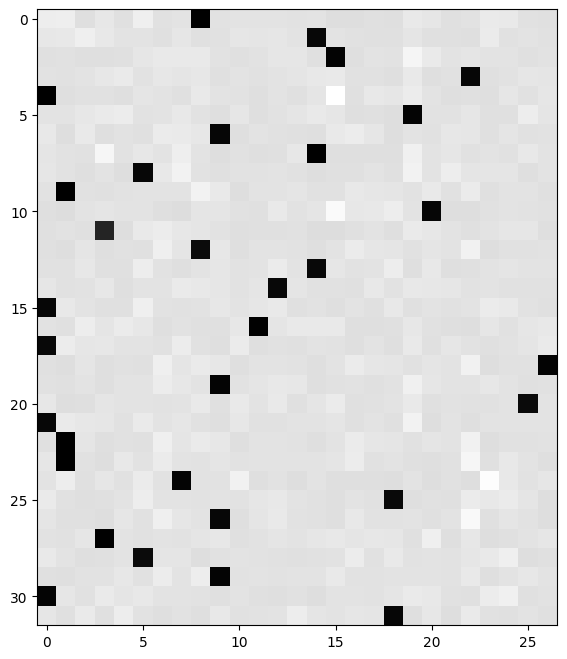

In [88]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray');
# уменьшаем неверные вероятности, увеличиваем верную

# Упражнение 3

In [89]:
# Градиенты батч нормализации

# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


### dhprebn = ???

In [90]:
# backward pass
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
# см видео за детальным объяснением
# -----------------

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


# Упражнение 4

In [91]:
# Обучим нейронную сеть без loss.backward()

In [92]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)  # embeddings
# 1 слой
W1 = torch.randn((n_embd*block_size, n_hidden) , generator=g) * (5/3)/((n_embd*block_size)**0.5)  # weights of 1 layer
b1 = torch.randn(n_hidden , generator=g) * 0.1  # bias of 1 layer, с batchnorm он бесполезен, используем просто так
# 2 слой
W2 = torch.randn((n_hidden, vocab_size) , generator=g) * 0.1  # weights of 2 layer
b2 = torch.randn(vocab_size , generator=g) * 0.1  # bias of 2 layer
# bacthnorm
bngain = torch.ones((1, n_hidden))  # масштаб batchnorm
bnbias = torch.zeros((1, n_hidden))  # смещение batchnorm

# Инциализируем параметры нестандартно, потому что с инициализацией нулями нам будет трудно убедиться, что мы правильно посчитали градиенты

parameters = [C, W1, b1, W2, b2, bngain, bnbias]  # all the parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12297


In [93]:
max_steps = 200000
batch_size = 64
n = batch_size
lossi = []

with torch.no_grad():
    for i in range(max_steps):
        
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        Xb, Yb = Xtr[ix], Ytr[ix]
        # forward pass
        # разрезан на более подробные кусочки, чтобы было удобно считать по каждому градиенты
        
        emb = C[Xb]  # [batch_size, block_size, embd], переводим индексы букв в векторы
        embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size], соединяем все векторы букв в один
        
        # Linear layer 1
        hprebn = embcat @ W1 + b1  # преактивация скрытого слоя
        
        # BatchNorm Layer
        bnmeani = 1/n*hprebn.sum(0, keepdim=True)  # запишем среднее на i итерации
        bndiff = hprebn - bnmeani
        bndiff2 = bndiff**2
        bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)  # поправка на число степеней свободы n-1 не n
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = bndiff * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        
        # Нелинейность
        h = torch.tanh(hpreact)
        
        # Linear layer 2
        logits = h @ W2 + b2  # [batch_size, vocab_size], выходной слой
        
        # cross entropy loss
        logit_maxes = logits.max(1, keepdim=True).values  # считаем максимумы для каждого выхода
        norm_logits = logits - logit_maxes  # вычитаем максимумы, тем самым повысим высилительную стабильнось без изменения результатаэ
        counts = norm_logits.exp()
        counts_sum = counts.sum(1, keepdim=True)
        counts_sum_inv = counts_sum**-1
        probs = counts * counts_sum_inv
        logprobs = probs.log()
        loss = -logprobs[range(n), Yb].mean()
        
        # backward pass
        # подсчет градиентов
        dlogprobs = torch.zeros_like(logprobs)
        dlogprobs[range(n), Yb] = -1.0/n
        dprobs = (1.0 / probs) * dlogprobs
        dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
        dcounts = counts_sum_inv * dprobs
        dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
        dcounts += torch.ones_like(counts) * dcounts_sum
        dnorm_logits = counts * dcounts
        dlogits = dnorm_logits.clone()
        dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
        dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        dhpreact = (1.0 - h**2) * dh
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnraw = bngain * dhpreact
        dbnbias = dhpreact.sum(0, keepdim=True)
        dbndiff = bnvar_inv * dbnraw
        dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
        dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
        dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
        dbndiff += (2*bndiff) * dbndiff2
        dhprebn = dbndiff.clone()
        dbnmeani = (-dbndiff).sum(0)
        dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
          for j in range(Xb.shape[1]):
            ix_ = Xb[k,j]
            dC[ix_] += demb[k,j]
        
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        
        # update
        lr = 0.1 if i < 100000 else 0.01
        for p, grad in zip(parameters, grads):
            p.data += -lr * grad
        
        # track stats
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
        lossi.append(loss.log10().item())

      0/ 200000: 3.7377
  10000/ 200000: 2.0695
  20000/ 200000: 1.9583
  30000/ 200000: 2.3761
  40000/ 200000: 2.0244
  50000/ 200000: 1.9043
  60000/ 200000: 2.1818
  70000/ 200000: 2.2578
  80000/ 200000: 1.9693
  90000/ 200000: 2.5467
 100000/ 200000: 2.0870
 110000/ 200000: 2.1258
 120000/ 200000: 2.0843
 130000/ 200000: 2.3504
 140000/ 200000: 2.3494
 150000/ 200000: 2.0417
 160000/ 200000: 2.3458
 170000/ 200000: 1.8615
 180000/ 200000: 1.9776
 190000/ 200000: 1.8469


In [94]:
# так как мы забыли про отслеживание скользящих статистик придется посчитать глобальные
with torch.no_grad():
    emb = C[Xtr]  # [batch_size, block_size, embd], переводим индексы букв в векторы
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size], соединяем все векторы букв в один
    hprebn = embcat @ W1 + b1  # преактивация скрытого слоя
    # замерим среднее значение и стандартное отклонение 1 раз
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True)

In [97]:
@torch.no_grad()  # декоратор отключает отслеживание градиентов
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]  # [batch_size, block_size, embd], переводим индексы букв в векторы
    embcat = emb.view(emb.shape[0], -1)  # [batch_size, embd*block_size], соединяем все векторы букв в один
    
    # Linear layer 1
    hprebn = embcat @ W1 + b1  # преактивация скрытого слоя
    
    # BatchNorm Layer, но используем глобальные статистики
    bndiff = hprebn - bnmean
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = bndiff * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    
    # Нелинейность
    h = torch.tanh(hpreact)
    
    # Linear layer 2
    logits = h @ W2 + b2  # [batch_size, vocab_size], выходной слой
    
    # cross entropy loss
    logit_maxes = logits.max(1, keepdim=True).values  # считаем максимумы для каждого выхода
    norm_logits = logits - logit_maxes  # вычитаем максимумы, тем самым повысим высилительную стабильнось без изменения результатаэ
    counts = norm_logits.exp()
    counts_sum = counts.sum(1, keepdim=True)
    counts_sum_inv = counts_sum**-1
    probs = counts * counts_sum_inv
    logprobs = probs.log()
    loss = -logprobs[range(len(x)), y].mean()
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.045433521270752
val 2.0989956855773926
